# Text Analysis

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from utils.analysis_helpers import *
from utils.clusters_helpers import *

c:\Users\david\anaconda3\envs\topic\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Choose features of the data to analyse
- Drop or select specifics conditions
- Differentiate between interviwer & participant

In [4]:
directory = '../interviews_corrected/5_conditions/**/' 

df = load_and_combine_csv(directory)
df = standardize_data(df)
df = calculate_word_char_counts(df)

df.to_csv("outputs/combined_data.csv", index=False)

Found 82 CSV files.
Standardized speaker labels.
Normalized text in 'Content' column.
Calculated 'Word_Count' and 'Character_Count' for each response.


In [5]:
print(df["Condition"].unique())
# Drop the rows equal to 0 for the column condition
df = df[df["Condition"] != 0]
print(df["Condition"].unique())

[1 'C' 'I' 0]
[1 'C' 'I']


In [6]:
# If only want to focus on participant speaker
df_participant = df[df["Speaker"] == "Participant"]
df_interviewer = df[df["Speaker"] == "Interviewer"]

## Word Count

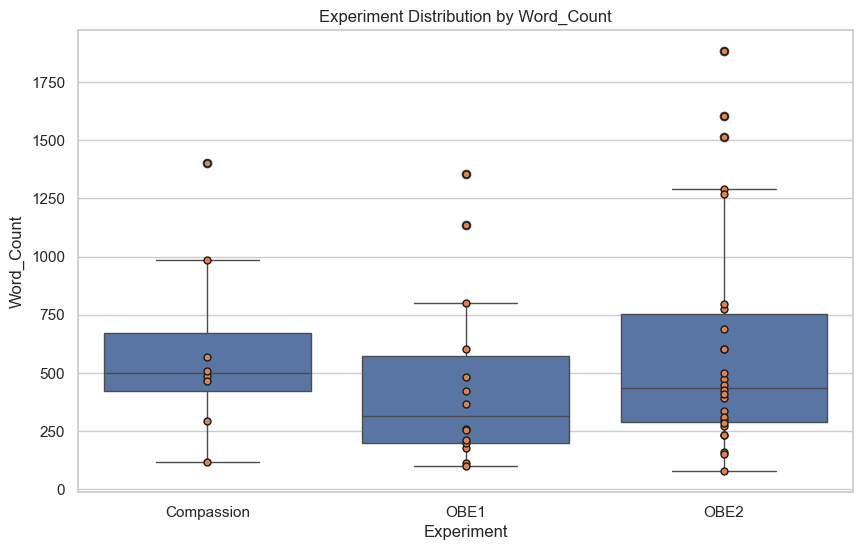

In [6]:
stripplot(aggregate_counts(df_participant,["Experiment","Id"]), 'Experiment', 'Word_Count')

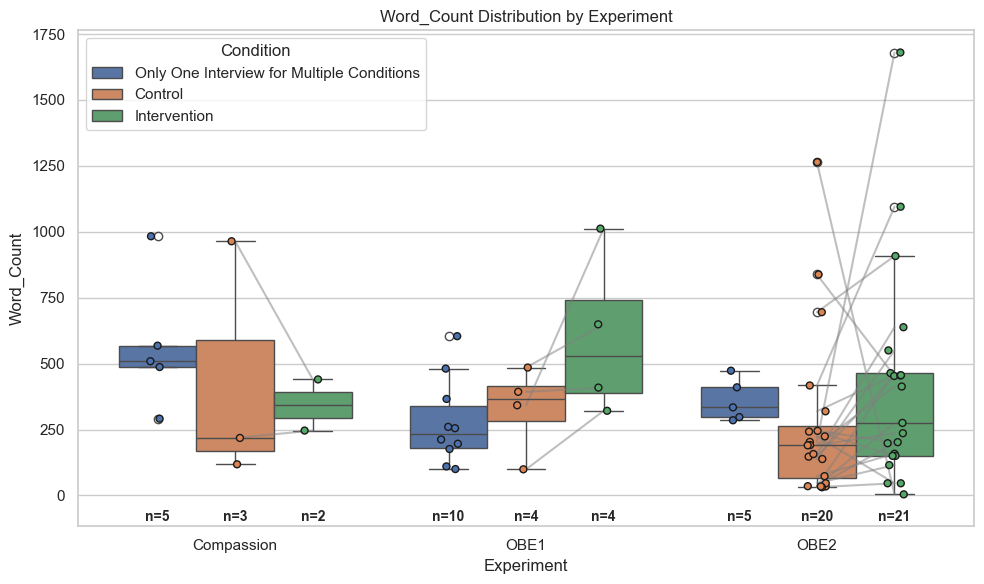

In [7]:
# Group by Id instead of File Name because the same participant can have the same condition in different interviews
stripplot_with_counts(aggregate_counts(df_participant, ['Experiment', "Id", "Condition"]), 'Experiment', 'Word_Count', 
                      hue_column='Condition', id_column="Id", legend_labels=["Only One Interview for Multiple Conditions","Control","Intervention"])#,file_name="stripplot_word_count_id.png")

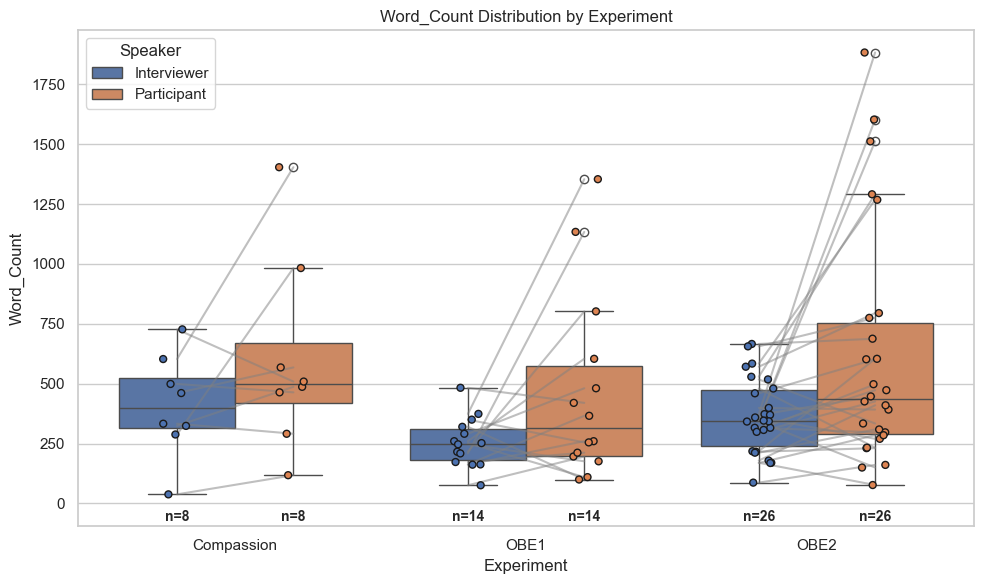

In [8]:
stripplot_with_counts(aggregate_counts(df, ['Experiment', "Id", 'Speaker']), 'Experiment', 'Word_Count', hue_column='Speaker', id_column="Id")

## Frequency & Unique Words

In [9]:
extra_words_to_exclude = ["yeah", "like", "okay" ,"really", "it", "yes", "could","kind","bit","think","that's"] 

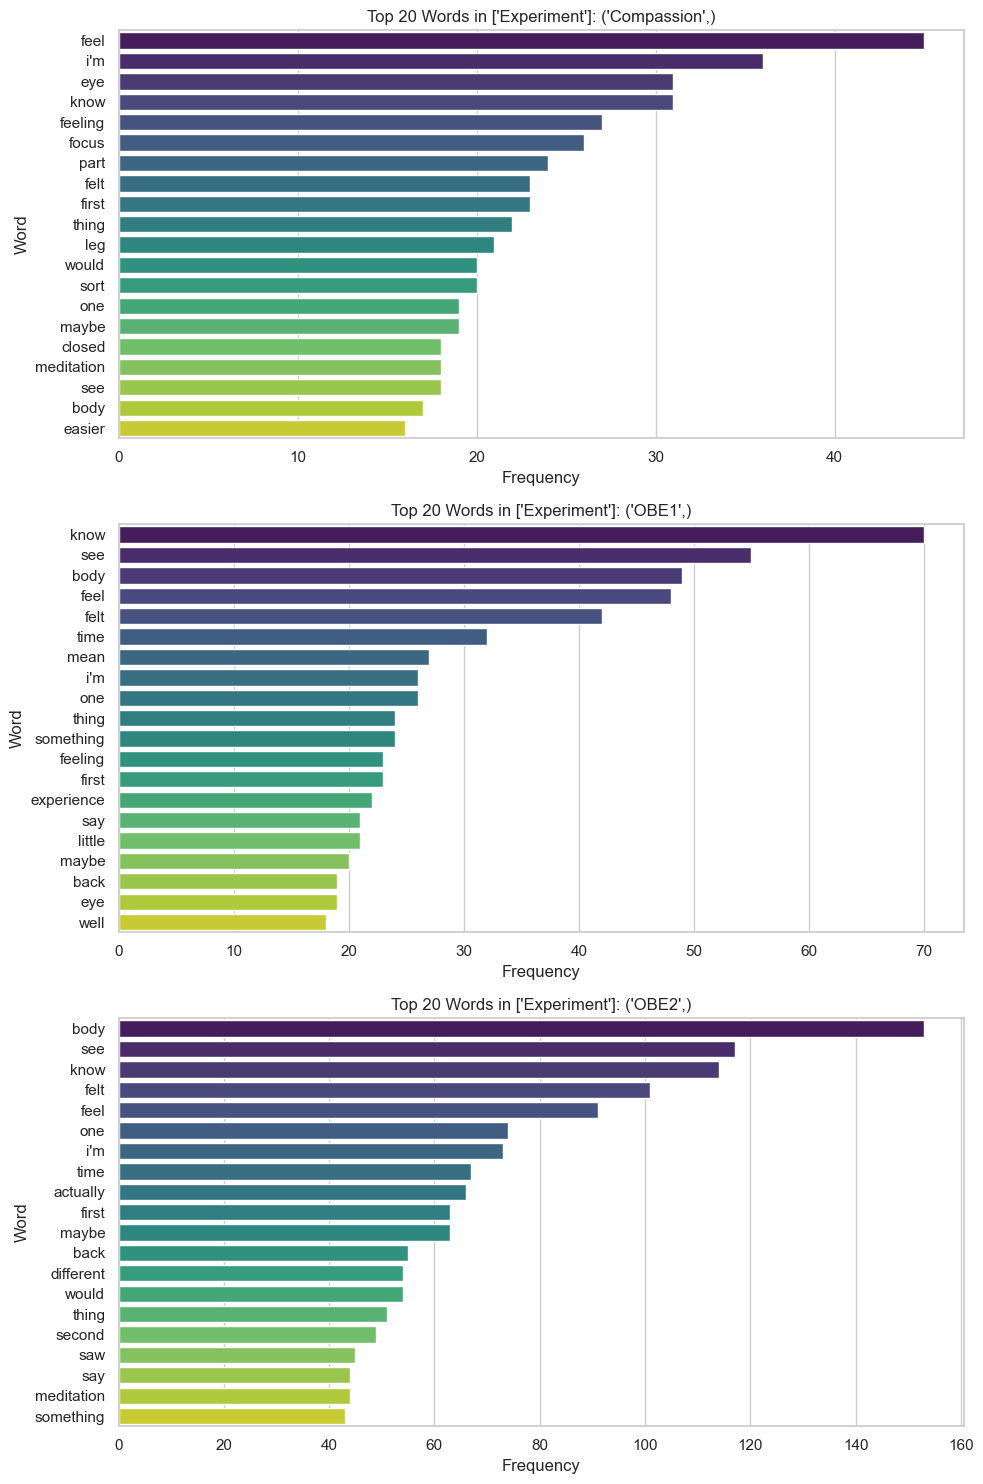

In [11]:
word_frequency_analysis(df_participant, groupby_column=["Experiment"], extra_stopwords=extra_words_to_exclude)

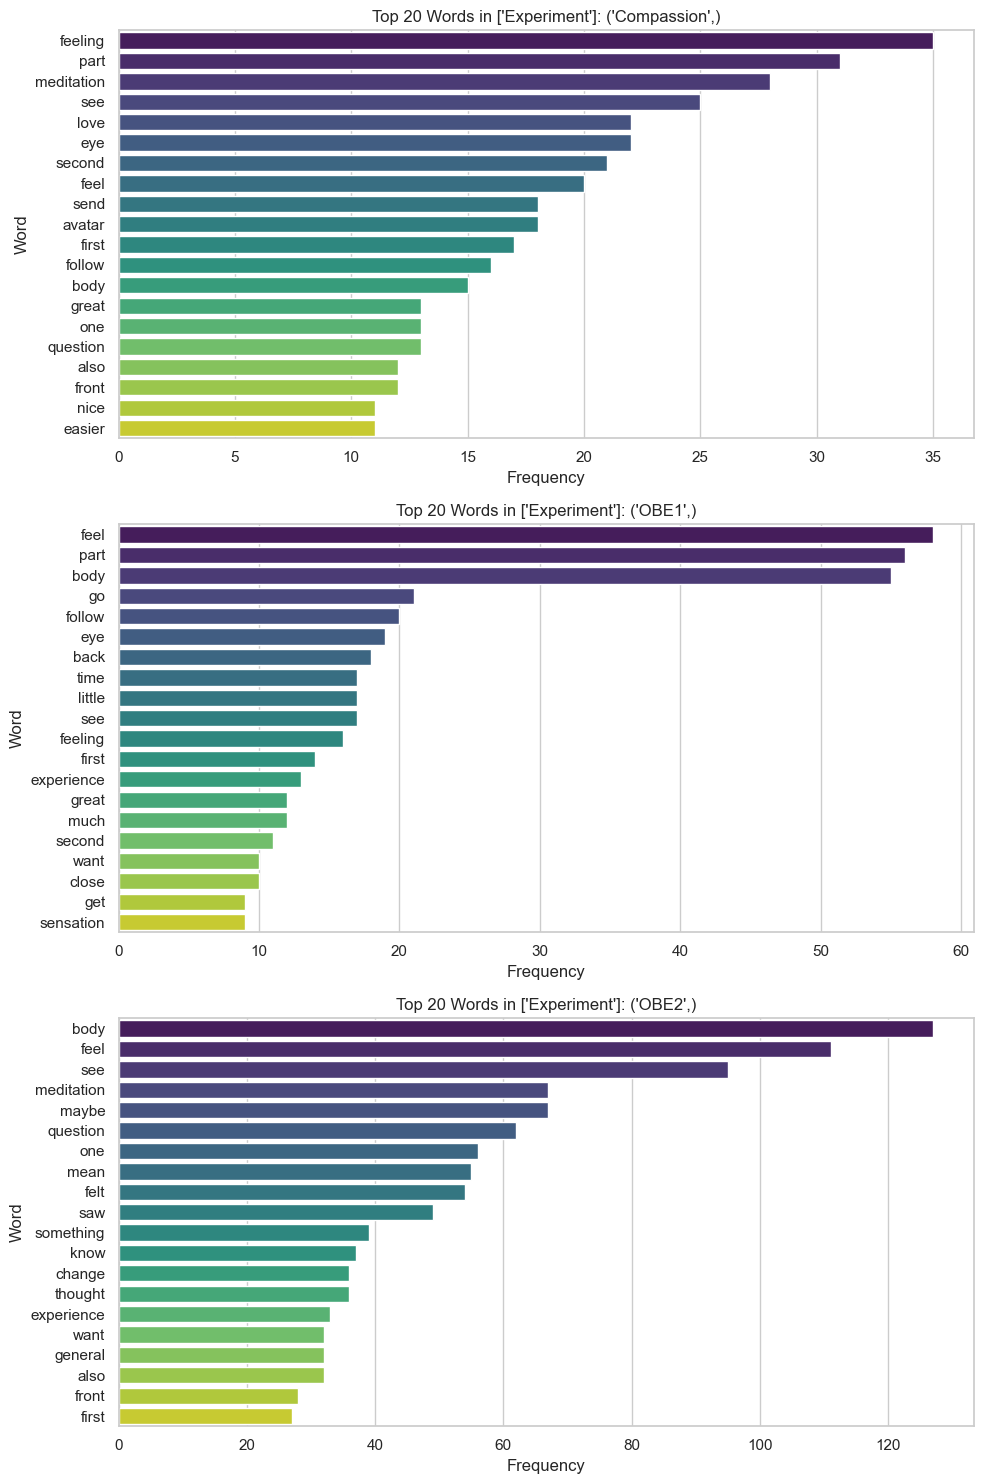

In [12]:
word_frequency_analysis(df_interviewer, groupby_column=["Experiment"], extra_stopwords=extra_words_to_exclude)

In [13]:
# You can specify any list of columns for grouping, e.g., ['Experiment', 'Condition']
unique_words_df_participant = count_unique_words(df_participant, groupby_columns=['Experiment', 'Condition'], omit_stop_words=True, extra_stopwords=extra_words_to_exclude)
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
unique_words_df_participant.to_csv("outputs/unique_words_participant.csv", index=False)

unique_words_df_interviewer = count_unique_words(df_interviewer, groupby_columns=['Experiment', 'Condition'], omit_stop_words=True, extra_stopwords=extra_words_to_exclude)
unique_words_df_interviewer = unique_words_df_interviewer.sort_values(by='Participant_Count', ascending=False)
unique_words_df_interviewer.to_csv("outputs/unique_words_interviewer.csv", index=False)

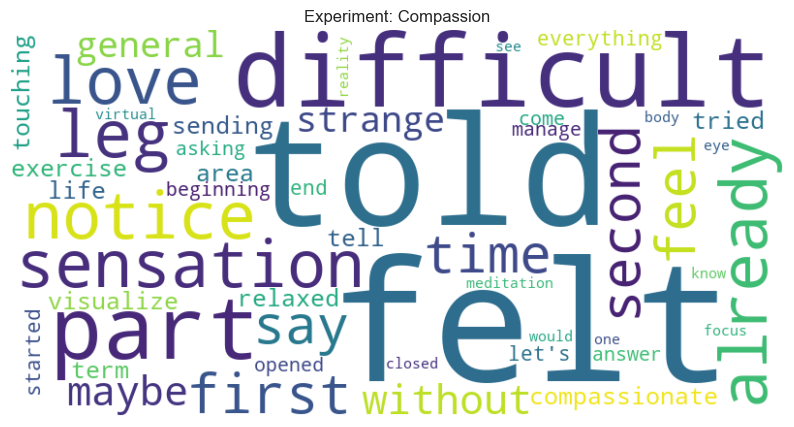

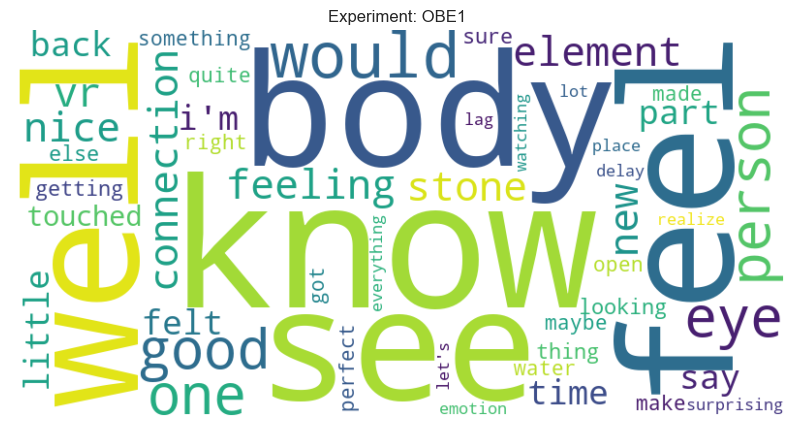

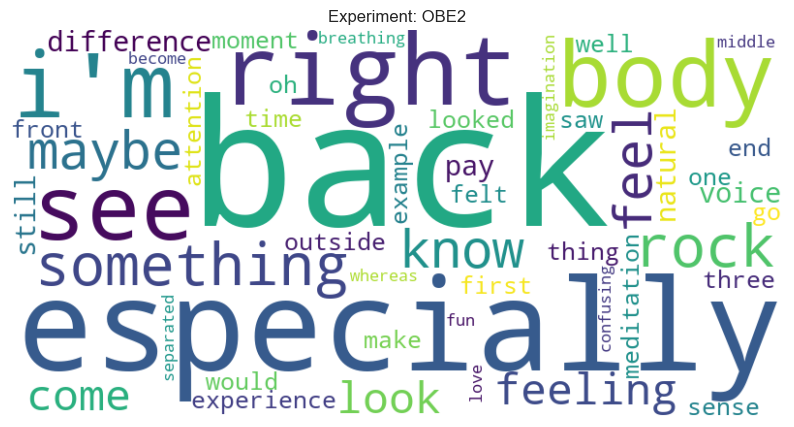

In [14]:
generate_word_clouds(unique_words_df_participant, groupby_columns=['Experiment'])

## Cluster participants (ID) by experiment

In [33]:
# Define extra stopwords
extra_stopwords = {'yeah', 'yes', 'like', 'you', 'know', 'um', 'uh', 'dont', 'really', 'think', 'feel'}

# Preprocess tex
df_participant.loc[:, 'preprocessed_content'] = df_participant['Content'].apply(preprocess_text)

# Group data by Experiment and Participant
grouped_df = df_participant.groupby(['Experiment', 'Id'])['preprocessed_content'].apply(' '.join).reset_index()

In [34]:
# Cluster using TF-IDF and KMeans
clustered_dfs_tfidf, embeddings_tfidf = cluster_text_kmeans(
    grouped_df,
    method='tfidf',
    n_clusters=2,  # Let the function determine the optimal number of clusters
    n_components=2
)

# Cluster using BERT embeddings and KMeans
clustered_dfs_bert, embeddings_bert = cluster_text_kmeans(
    grouped_df,
    method='bert',
    n_clusters=2,
    n_components=2
)

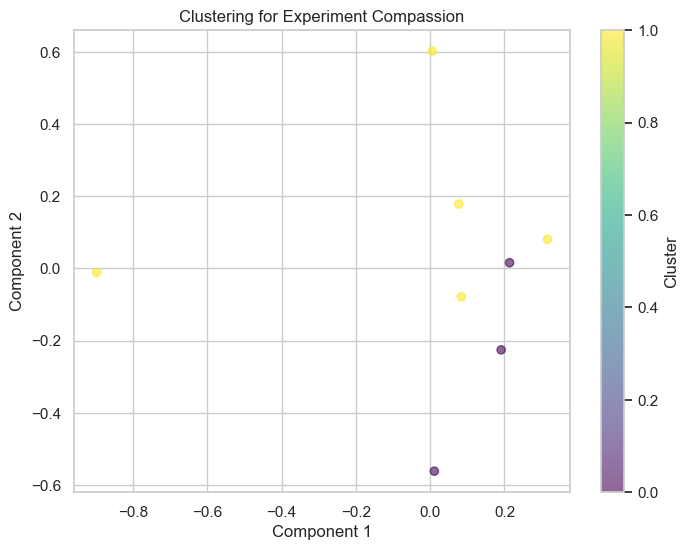

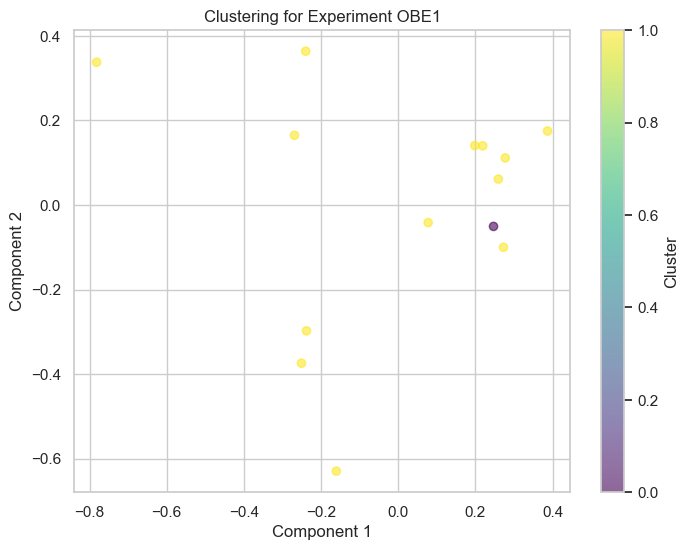

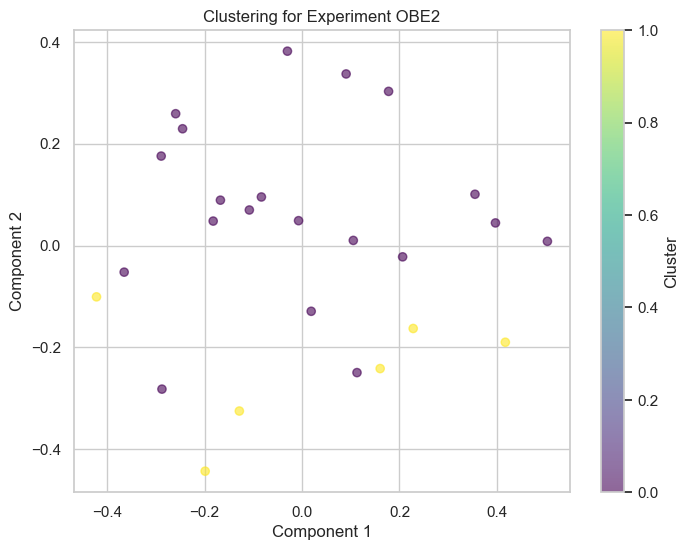

In [35]:
visualize_clusters(clustered_dfs_tfidf, n_components=2)

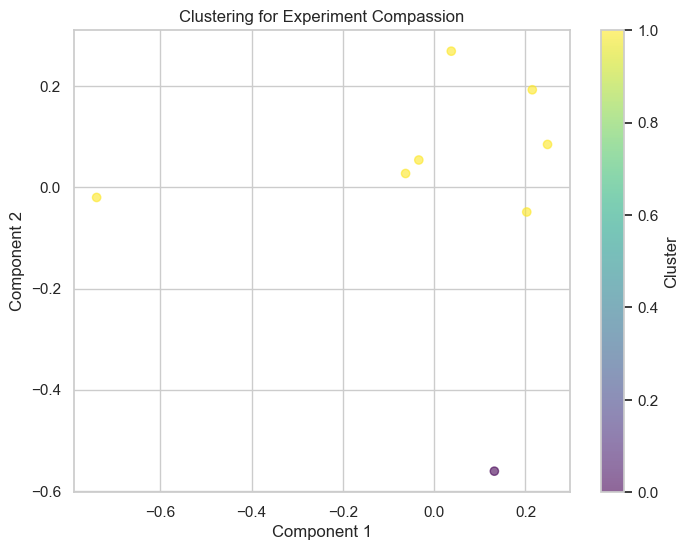

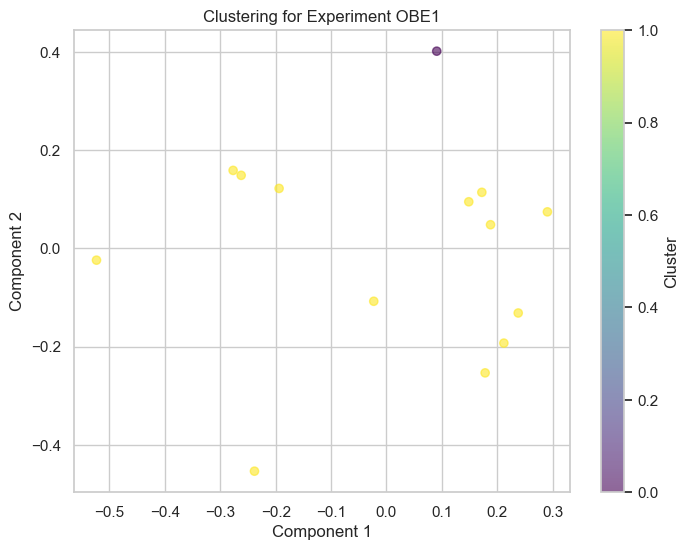

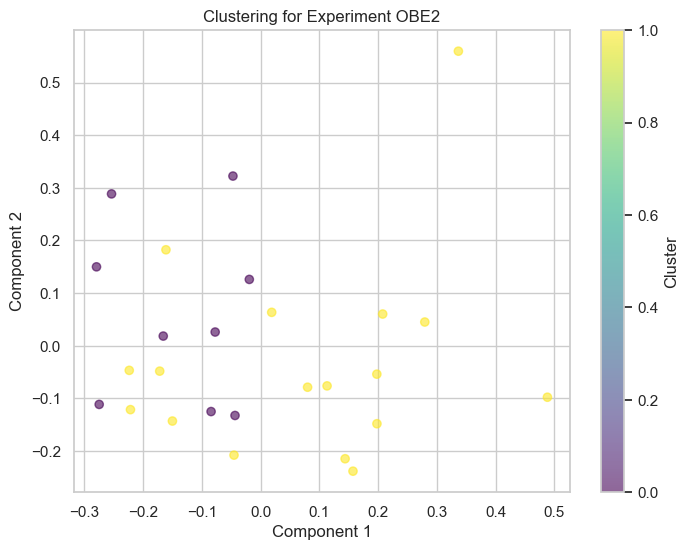

In [36]:
visualize_clusters(clustered_dfs_bert, n_components=2)

## Clusters of answers participants -> Topic Modeling

In [62]:
# Define extra stopwords
extra_stopwords = {'yeah', 'yes', 'like', 'you', 'know', 'um', 'uh', 'dont', 'really', 'think'}

# Preprocess text
df_participant['preprocessed_content'] = df_participant['Content'].apply(
    lambda x: preprocess_text(x, extra_stopwords=extra_stopwords)
)
# Group data by Experiment and Participant
grouped_df = df_participant.groupby(['Experiment', 'Id'])['preprocessed_content'].apply(' '.join).reset_index()

C:\Users\david\AppData\Local\Temp\ipykernel_3524\2009073391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_participant['preprocessed_content'] = df_participant['Content'].apply(


In [64]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Dictionary to store models for each experiment
experiment_models = {}

for experiment in grouped_df['Experiment'].unique():
    print(f'Fitting LDA for {experiment}')
    # Subset data for the experiment
    experiment_data = grouped_df[grouped_df['Experiment'] == experiment]
    
    # Vectorize the text
    vectorizer = CountVectorizer(max_features=1000, stop_words='english')
    text_matrix = vectorizer.fit_transform(experiment_data['preprocessed_content'])
    
    # Fit LDA
    n_topics = 5  # Adjust based on the size and complexity of the experiment
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    topic_matrix = lda_model.fit_transform(text_matrix)
    
    # Store the model and vectorizer
    experiment_models[experiment] = {
        'lda_model': lda_model,
        'vectorizer': vectorizer,
        'topic_matrix': topic_matrix,
        'experiment_data': experiment_data
    }

Fitting LDA for Compassion
Fitting LDA for OBE1
Fitting LDA for OBE2


In [67]:
experiment_models

{'Compassion': {'lda_model': LatentDirichletAllocation(n_components=5, random_state=42),
  'vectorizer': CountVectorizer(max_features=1000, stop_words='english'),
  'topic_matrix': array([[1.50249293e-03, 1.50999918e-03, 1.48194682e-03, 9.94008972e-01,
          1.49658931e-03],
         [1.43066789e-03, 1.43685859e-03, 1.41892958e-03, 9.94286227e-01,
          1.42731650e-03],
         [4.36331536e-04, 9.98264966e-01, 4.30415280e-04, 4.35136526e-04,
          4.33151019e-04],
         [9.95438170e-01, 1.15005814e-03, 1.13023158e-03, 1.14392598e-03,
          1.13761392e-03],
         [5.53067816e-03, 9.78122816e-01, 5.40953026e-03, 5.47791894e-03,
          5.45905702e-03],
         [7.35291295e-04, 9.97072645e-01, 7.24984488e-04, 7.33386580e-04,
          7.33692391e-04],
         [2.43373471e-03, 2.44049057e-03, 2.41012996e-03, 2.44568210e-03,
          9.90269963e-01],
         [1.35079223e-03, 9.94588775e-01, 1.33426760e-03, 1.37224039e-03,
          1.35392435e-03]]),
  'experime

In [65]:
def display_topics(lda_model, vectorizer, num_words=10):
    """Display top words for each topic."""
    feature_names = vectorizer.get_feature_names_out()
    topics = []
    for idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]
        print(f"Topic {idx + 1}: {', '.join(top_words)}")
        topics.append(top_words)
    return topics

In [ ]:
for experiment in df_participant["Experiment"].unique():
    
    lda_model = experiment_models[experiment]['lda_model']
    vectorizer = experiment_models[experiment]['vectorizer']
    topic_matrix = experiment_models[experiment]['topic_matrix']

    print(f"Topics for {experiment}:")
    experiment_topics = display_topics(lda_model, vectorizer)

    # Visualize topic distribution per participant
    topic_columns = [f"Topic_{i+1}" for i in range(topic_matrix.shape[1])]
    for i, col in enumerate(topic_columns):
        experiment_data[col] = topic_matrix[:, i]

    # Set participant IDs as index for the heatmap
    heatmap_data = experiment_data.set_index('Id')[topic_columns]

    # Plot heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".2f", cbar_kws={'label': 'Proportion'})
    plt.title(f"Topic Distribution Per Participant in {experiment}")
    plt.xlabel("Topics")
    plt.ylabel("Participant ID")
    plt.show()

Topics for Compassion:
Topic 1: feel, kind, leg, felt, eye, trying, condition, didnt, looking, open
Topic 2: im, feeling, thing, feel, sort, bit, focus, leg, eye, maybe
Topic 3: asking, stuff, reason, challenge, hardest, voice, challenging, new, selfawareness, phrase
Topic 4: feel, eye, closed, felt, meditation, second, place, hand, say, room
Topic 5: easier, feel, say, seeing, selflove, eye, meditation, virtual, reality, body


ValueError: Length of values (8) does not match length of index (26)

In [43]:
def display_experiment_topics(experiment, experiment_topic_models, no_top_words=10):
    # Get the model and vectorizer for the experiment
    lda_model = experiment_topic_models[experiment]['lda_model']
    vectorizer = experiment_topic_models[experiment]['vectorizer']

    # Display topics
    feature_names = vectorizer.get_feature_names_out()
    for idx, topic in enumerate(lda_model.components_):
        print(f"Experiment: {experiment}, Topic {idx+1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [38]:
# Aggregate topic proportions by experiment
experiment_topic_averages = grouped_df.groupby('Experiment')[topic_columns].mean()

# Preview the average topic proportions by experiment
print(experiment_topic_averages)

             Topic_1   Topic_2   Topic_3
Experiment                              
Compassion  0.449976  0.180585  0.369439
OBE1        0.285099  0.223002  0.491899
OBE2        0.294983  0.341337  0.363679


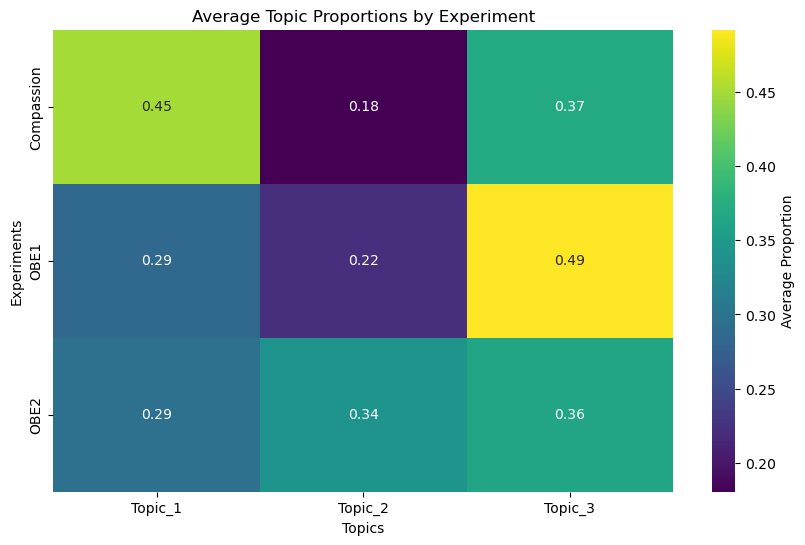

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap for topic proportions
plt.figure(figsize=(10, 6))
sns.heatmap(experiment_topic_averages, annot=True, fmt=".2f", cmap="viridis", cbar_kws={'label': 'Average Proportion'})
plt.title("Average Topic Proportions by Experiment")
plt.xlabel("Topics")
plt.ylabel("Experiments")
plt.show()


In [40]:
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Display the top words for each topic
feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names)


Topic 1:
felt body feel didnt im bit kind thing okay eye
Topic 2:
body feel maybe different thats mean kind okay say im
Topic 3:
body feel felt im time bit actually second thing feeling
